In [1]:
import numpy as np
import pandas as pd
import pickle
import bcolz
import mysql.connector

from nltk import word_tokenize
from sklearn.cluster import KMeans
from sentence_transformers import util
import spacy

## Load Data

In [2]:
chunksize = 100000
chunks = []
chunk_no=0
for chunk in pd.read_csv('./actor_action_desc.csv', chunksize=chunksize):
    print(chunk_no)
    chunks.append(chunk)
    chunk_no+=1
    if chunk_no==2:
        break

0
1


In [3]:
df_case_action = pd.concat(chunks,ignore_index=True)
del chunks
df_case_action.columns = ['Actor','Action','Description']
df_case_action.head()

,Actor,Action,Description
0,Plaintiff,Application filed,Application filed on 04/27/2011 at Boston Muni...
1,Plaintiff,Appearance filed,"Appearance for Potfolio Recovery Associates, L..."
2,Plaintiff,Application filed,Supplementary process application filed; filin...
3,Court,Event scheduled,HEARING SCHEDULED for 06/09/2011 10:00 AM.
4,Court,Return of Service,Return of service on complaint and summons to ...


In [4]:
df_case_action.tail()

,Actor,Action,Description
199995,NaN,Counsel added,"Attorney Sardella, Esq., Todd Michael represen..."
199996,Plaintiff,Fee due,Small Claims Filing Fee Surcharge due. Receip...
199997,Court,Fee due,Small Claims Filing Fee for claim Over $500 bu...
199998,Court,Event scheduled,Event Scheduled\n\nEvent: Magistrate Hearing\n...
199999,NaN,NaN,Satisfaction of judgment demonstrated and orde...


In [5]:
df_case_action['Actor'].notnull() & df_case_action['Action'].notnull()

0          True
1          True
2          True
3          True
4          True
          ...  
199995    False
199996     True
199997     True
199998     True
199999    False
Length: 200000, dtype: bool

In [7]:
mydb = mysql.connector.connect(host='73.38.248.152', user='buspark', password='U@5p1r3!')

if (mydb):
    print("Connection Successful")

else:
    print("Connection Unsuccessful")

mycursor = mydb.cursor()

mycursor.execute("Show databases")

for db in mycursor:
    print(db)

Connection Successful
('information_schema',)
('civica_courtdocs',)
('wp_courtdocs',)
('wp_courtdocs_NORMALIZED',)


In [8]:
df_case_action = pd.read_sql("SELECT * FROM wp_courtdocs.cdocs_case_action_index as c_a_index \
                          WHERE c_a_index.action = ' ' and c_a_index.actor = ' ' LIMIT 0, 20000;"
                          ,con = mydb)

In [9]:
df_case_action = df_case_action.rename(columns={'description':'Description',"action":"Action","actor":"Actor"})

## Load Embeddings

In [10]:
nlp = spacy.load('en_core_web_md')

In [11]:
def preprocess(string):
    # this function will make the following changes
    # name of person -> PER
    # name of company -> ORG
    doc = nlp(string)
    for ent in doc.ents:
        if ent.label_ == 'ORG':
            string = string.replace(ent.text,'ORG')
        elif ent.label_ == 'PERSON':
            string = string.replace(ent.text,'PERSON')
        elif ent.label_ == 'DATE':
            string = string.replace(ent.text,'DATE')
        
    return string
    

In [12]:
vectors = bcolz.open('./glove.6B.50d.dat')[:]
words = pickle.load(open('./glove.6B.50d_words.pkl', 'rb'))
word2idx = pickle.load(open('./glove.6B.50d_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [13]:
text = df_case_action['Description'].iloc[:20000].astype('str').apply(lambda x: preprocess(x)).values
text_embeddings = np.zeros((text.shape[0],50))
for i,sentence in enumerate(text):
    tokens = word_tokenize(sentence)
    sentence_emb = []
    for token in tokens:
        try:
            sentence_emb.append(glove[token.lower()])
        except:
            continue
    if len(sentence_emb) == 0:
        print(sentence)
    else:
        text_embeddings[i] = np.mean(np.array(sentence_emb),axis=0)
    




Order-mailed




Order-mailed


















Agreement/PERSON

Agreement-JB




ORGfiled


















Affidavit-PERSON












## Encode Sentences

In [92]:
text_embeddings.shape

(20000, 50)

## Clustering

### community detection algorithm

In [14]:
def community_detection(embeddings, threshold=0.75, min_community_size=10, init_max_size=1000):
    """
    Function for Fast Community Detection
    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).
    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [134]:
clusters = community_detection(features, min_community_size=2, threshold=0.90)
len(clusters)

440

In [29]:
df_case_action.iloc[clusters[0]]['Action'].value_counts()

Event resulted                    934
System Notes                      473
Judgment                          436
Capias                            391
Statement of small claim filed    381
                                 ... 
Motion to Substitute a Party        1
Notice of potential default         1
Amended Answer filed                1
Interpreter requested               1
Motion to assess damages            1
Name: Action, Length: 84, dtype: int64

In [135]:
df_clustered_community = df_case_action.iloc[:20000].copy()
df_clustered_community['cluster'] = -1
for i in range(len(clusters)):
    df_clustered_community.at[clusters[i],'cluster']= i

In [149]:
df_clustered_community[ df_clustered_community['cluster'] == 12][['Description']]

,Description
187,Request of Massachusetts Housing Finance Agenc...
372,"Returned Mail deft Marchand, ret to sender"
396,Order: JUDGEMENT VACATED; CASE DISMISSED SEE S...
791,Findings: finding for possessiion. Deft. defau...
839,Misc Entry: No capias to issue per request of...
...,...
19696,Order for Informal Probate of Will and/or Appo...
19812,Order for Informal Probate of Will and/or Appo...
19872,Order for Informal Probate of Will and/or Appo...
19941,Order for Informal Probate of Will and/or Appo...


In [58]:
df_clustered_community.to_csv('./community_clustering.csv',index=False)

In [128]:
for i in range(len(clusters)):
    temp_action = df_case_action.iloc[clusters[i]]['Action'].value_counts()
    temp_actor = df_case_action.iloc[clusters[i]]['Actor'].value_counts()
    print(len(temp_action),len(temp_actor))
	

7 1
30 4
1 2
1 1
4 1
7 2
1 1
1 1
7 3
1 1
5 1
4 1
2 3
1 1
1 3
1 1
1 1
2 3
1 1
1 1
3 3
2 1
1 1
1 1
1 3
1 1
1 1
1 2
1 1
1 1
1 1
3 2
1 1
1 1
1 1
4 2
1 1
2 3
1 1
2 1
1 1
1 1
1 1
1 1
1 1
1 6
2 1
1 1
2 1
1 1
1 1
2 1
2 1
2 1
1 5
2 2
2 1
1 1
1 1
2 2
1 1
1 1
1 5
1 1
1 1
1 1
1 1
1 1
1 5
0 0
2 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 2
1 1
1 1
1 1
2 2
3 1
2 2
0 0
1 1
2 1
1 1
1 1
1 1
1 0
1 1
1 1
1 0
1 1
2 1
1 1
1 1
0 0
1 1
1 1
1 1
4 2
2 1
1 3
1 1
0 2
4 3
1 1
0 0
1 1
1 1
0 0
0 0
1 2
3 3
0 0
1 1
1 1
0 0
1 1
4 3
1 1
4 1
3 1
1 2
1 2
0 0
0 2
1 2
1 1
1 1
1 1
2 1
2 2
1 1
0 0
0 0
0 0
0 0
1 1
1 1
0 0
3 3
1 1
3 1
1 1
1 2
4 2
0 0
2 1
2 1
3 2
1 2
1 2
1 1
1 3
1 2
1 1
1 1
1 1
2 2
1 3
0 0
0 0
0 0
0 0
1 1
0 0
0 2
1 1
1 2
1 1
2 2
1 1
1 1
1 1
2 1
1 2
3 2
0 0
0 0
1 1
1 1
1 1
0 0
1 1
2 1
2 2
0 0
1 1
1 1
2 2
1 1
1 2
2 2
2 1
1 1
2 2
3 1
1 1
0 0
1 0
1 1
0 0
0 0
0 0
2 1
0 0
1 1
1 1
1 1
2 3
0 1
0 0
1 2
0 0
3 1
0 1
4 1
2 1
1 1
2 2
1 2
1 1
1 1
1 1
1 1
1 1
1 1
1 2
2 1
2 1
0 3
0 0
1 2
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
2 2
1 1
1 1
1 2

### Faiss KMeans

In [24]:
import faiss

In [25]:
class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X, y):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]

In [185]:
f_kmeans = FaissKMeans(n_clusters=250)
f_kmeans.fit(text_embeddings,None)

In [177]:
def predict_list_distinct(cluster_model,test_embeddings,original_df):
    preds = cluster_model.predict(test_embeddings)
    df_clustered = original_df.iloc[:20000].copy()
    df_clustered['cluster'] = preds
    for i in range(cluster_model.n_clusters):
        temp_actions = len(df_clustered[df_clustered['cluster'] == i]['Action'].value_counts())
        temp_actors = len(df_clustered[df_clustered['cluster'] == i]['Actor'].value_counts())
        print('distinct',temp_actions,temp_actors)
    return df_clustered

In [187]:
# df_clustered = predict_list_distinct(f_kmeans,text_embeddings,df_case_action)
preds = f_kmeans.predict(text_embeddings)
df_clustered = df_case_action.iloc[:20000].copy()
df_clustered['cluster'] = preds

In [216]:
df_clustered[df_clustered['cluster'] == 12][['Description']].values

array([['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Reasonable Accomodation Agreement'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Joint Stipulation of Dismissal'],
       ['Joint Stipulation of Dismissal-ok PQM'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Voluntary Executor'],
       ['Statement of Vol

In [194]:
df_clustered.to_csv('./faiss_clustering_last.csv',index=False)

### Sklearn KMeans

In [53]:
kmeans = KMeans(n_clusters = 161, init = 'k-means++', random_state = 42)
kmeans.fit(text_embeddings)

KMeans(n_clusters=161, random_state=42)

In [38]:
preds = kmeans.predict(text_embeddings)

In [44]:
for i in range(len(preds)):
    print(text[i])
    print('predicted : ',preds[i])
    print('actual : ',df.at[i,'actor'])
    print('\n')
    if i==20:
        break

Certificate of Death
predicted :  4
actual :  Administrator/rix CTA


Appointment of Agent
predicted :  0
actual :  Administrator/rix CTA


Petition for Administration CTA
predicted :  3
actual :  Administrator/rix CTA


Certificate of Death (Mary Lorraine Vernaglia)
predicted :  2
actual :  Administrator/rix CTA


Petition for Sale of Real Estate
predicted :  0
actual :  Administrator/rix CTA


Petition for Administration CTA
predicted :  3
actual :  Administrator/rix CTA


Copy of Will dated 09/19/1989 3p.
predicted :  2
actual :  Administrator/rix CTA


Certificate of Death
predicted :  4
actual :  Administrator/rix CTA


Petition for Order of Complete Settlement
predicted :  0
actual :  Administrator/rix CTA


Petition for Administration
predicted :  3
actual :  Administrator/rix CTA


Certificate of Death
predicted :  4
actual :  Administrator/rix CTA


Petition for Administration CTA
predicted :  3
actual :  Administrator/rix CTA


Certificate of Death
predicted :  4
actual :  Ad

## Heirarchical clustering

In [26]:
from sklearn.cluster import KMeans,AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import numpy as np

In [219]:
text_embeddings.shape

(20000, 50)

In [27]:
def plot_dendrogram_(model, **kwargs):
    # this function was taken from the sklearn docs 
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

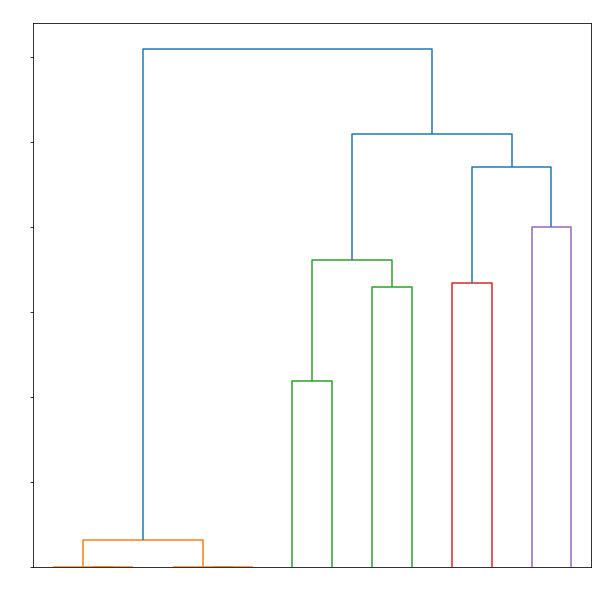

In [230]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(text_embeddings)
color = 'w'
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram',c=color)
# plot the top three levels of the dendrogram
plot_dendrogram_(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).",c=color)
plt.xticks(c=color)
plt.yticks(c=color)
plt.show()


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer( max_features=100,
                                  stop_words='english',
                                 use_idf=True, ngram_range=(1,1))

tfidf_matrix = tfidf_vectorizer.fit_transform(df_case_action['Description'].values) #fit the vectorizer to synopses

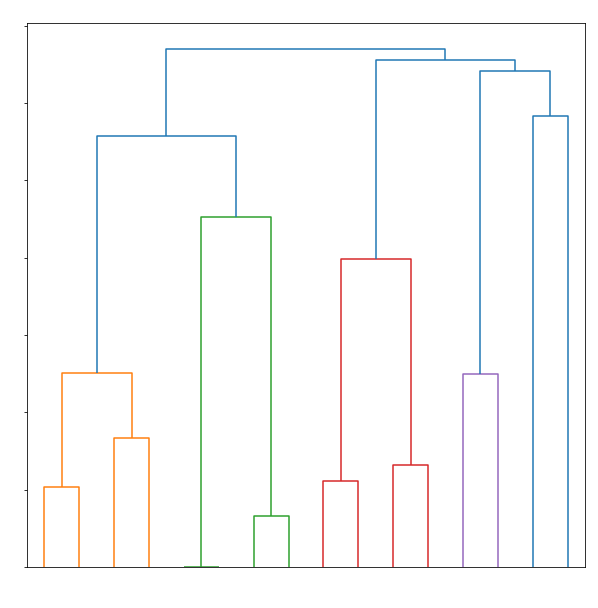

In [29]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(tfidf_matrix.toarray())
color = 'w'
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram',c=color)
# plot the top three levels of the dendrogram
plot_dendrogram_(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).",c=color)
plt.xticks(c=color)
plt.yticks(c=color)
plt.show()


In [81]:
pos_features = []
tags = {}
for text in df_case_action['Description'].values:
    temp = []
    doc = nlp(text)
    for token in doc:
        temp.append(token.pos_)
        if token.pos_ not in tags:
            tags[token.pos_] = 1
    pos_features.append(temp)

i = 0
for k,v in tags.items():
    tags[k] = i
    i+=1
max_len = max([len(x) for x in pos_features])

In [86]:
features = np.zeros((len(pos_features),max_len))
features[:,:] = -1
for i,item in enumerate(pos_features):
    temp = [tags[pos] for pos in item]
    features[i,:len(temp)] = temp

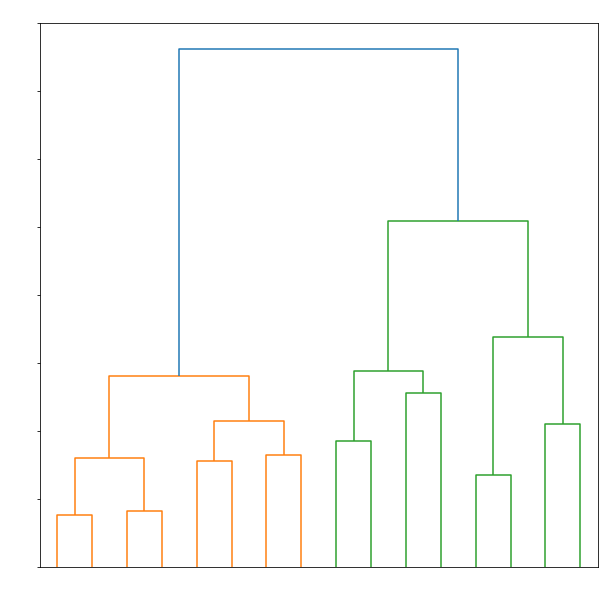

In [88]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(features)
color = 'w'
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram',c=color)
# plot the top three levels of the dendrogram
plot_dendrogram_(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).",c=color)
plt.xticks(c=color)
plt.yticks(c=color)
plt.show()


In [95]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=16)
model.fit(features)

AgglomerativeClustering(n_clusters=16)

In [96]:
assignments = model.labels_
df_h = df_case_action.copy()
df_h['cluster'] = assignments

In [171]:
df_h[df_h['cluster']==0][['Description']]

,Description
2,"An Interested Person,Johanna Soris, Asst. Atto..."
33,Disclaimer of Interest in Life Insurance Polic...
57,"Attorney Daniels, Jr., Esq., Richard S represe..."
78,"Bond James C. Brown of Walp[ole,Mass personal ..."
111,CMC held; continued with notice for: Pretrial ...
...,...
19934,SURCHARGE 185C:Entry of Action filed (Section ...
19946,"Attorney O'Brien, Jr., Esq., Lawrence E repres..."
19947,Case transferred out from Somerville District ...
19968,SERVICE RETURNED: Jason Silver a/k/a Jason P.\...


In [179]:
list(df_h[df_h['cluster']==6]['Description'])

['Citation Filed; Served as Ordered',
 'Letters of Authority for Personal Representative',
 'Citation Filed; Served as Ordered',
 'Letters of Authority for Personal Representative',
 'Assent of Mary Jeanne Mullen',
 'Citation Filed; Served as Ordered',
 'Decree Appointing Fiduciary dated 12/29/10',
 'Judgment on First and Final Account',
 'Citation Filed; Served as Ordered',
 'Letters of Authority for Personal Representative',
 'Citation Filed; Served as Ordered',
 'Letters of Authority for Personal Representative',
 'Citation Filed; Served as Ordered',
 'Letters of Authority for Personal Representative',
 'Statement of Confirmation of Testamentary Trustee',
 'Letters of Authority for Personal Representative',
 'Citation Filed; Served as Ordered',
 'Bond without Approved Unassigned\n\n\n\n',
 'Judgment on First and Final Account 12/7/11',
 'R 41(a)(1) Voluntary Dismissal',
 ' Defendant Discovery Requests\n\n',
 'R 41(a)(1) Voluntary Dismissal',
 'Letters of Authority for Personal Repre